## A7: Forecasting with Neural Networks

## Import Modules

In [1]:
# Common imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#tensorflow imports
import tensorflow as tf
from tensorflow import keras

#sklearn imports
import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.linear_model import SGDRegressor, LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

## Function Definitions

In [2]:
#function to verify the existence of a file in the current working directory and download it if not
import os,urllib, urllib.request, sys, tarfile
def downloadDataResource(file, sourcePath, compressed=None):
    if not os.path.isfile(file):
        try:
            urllib.request.urlretrieve(sourcePath+(compressed if compressed else file),(compressed if compressed else file))
            print("Downloaded", (compressed if compressed else file) )
            if compressed:
                ucomp = tarfile.open(compressed)
                ucomp.extractall()
                ucomp.close()
                print("File uncompressed.")
        except:
            print("ERROR: File", (compressed if compressed else file), "not found. Data source missing.")
    else:
        print("Data resource", file, "already downloaded.")

In [3]:
#function provided that plots the learning curve for neural networks
def nn_plot_learning_curve( history ):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    ymin, ymax = [], []
    for x in history.history.keys():
        ymax.append( max(history.history[x]))
        ymin.append( min(history.history[x]))
    plt.gca().set_ylim(min(ymin)*.95, max(ymax)*1.05)
    plt.xlabel("EPOCHS")
    plt.show()

In [4]:
#function that shows a learning curve for any model that has predict or fit methods
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator,X,y,ylim=None,cv=None,n_jobs=None,train_sizes=np.linspace(0.1, 1.0, 20),scoring = 'neg_root_mean_squared_error'):
    
    _, axes = plt.subplots(1, 1, figsize=(10, 5))    
    axes.set_title('Learning Curve')
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel(scoring)

    train_sizes, train_scores, test_scores= learning_curve(estimator,X,y,cv=cv,n_jobs=n_jobs,train_sizes=train_sizes,scoring = scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes,train_scores_mean - train_scores_std,train_scores_mean + train_scores_std,alpha=0.1,color="r")
    axes.fill_between(train_sizes,test_scores_mean - test_scores_std,test_scores_mean + test_scores_std,alpha=0.1,color="g")
    axes.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    axes.plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score")
    axes.legend(loc="best")
    plt.show()
    
    return

#code to prevent warnings that can occur as a result of this function
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [5]:
#function to plot actual values vs. predicted values
def plot_actual_pred( actual, prediction ):
    plt.plot(actual, ".-", alpha=.6, label="Actual")
    plt.plot(prediction, ".-", alpha=.6, label="Prediction")
    plt.grid(True)
    plt.legend()
    plt.show()

In [6]:
#function to plot a series as well as the predicted and value to be predicted (if known)
def plot_series(series, y=None, y_pred=None):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(range(series.shape[0], series.shape[0]+y.shape[0]), y, "bx-", markersize=10, label="Actual")
    if y_pred is not None:
        plt.plot(range(series.shape[0], series.shape[0]+y_pred.shape[0]), y_pred, "ro-", label="Prediction")
    plt.grid(True)
    plt.legend()
    plt.show()

In [7]:
#function to plot a series as well as the predicted and value to be predicted (if known)
def plot_series2(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])


## Source Data

In [8]:
#download data files if not currently found in your datasets directory (under the current working directory)
path = 'https://raw.githubusercontent.com/SueMcMetzger/MachineLearning/main/chpt15/'

filename = "NVDA.csv"
downloadDataResource(filename,path)
#create a dataframe with the data from the CSV file
nvidia = pd.read_csv(filename)

filename = "Crypto.csv"
downloadDataResource(filename,path)
#create a dataframe with the data from the CSV file
crypto = pd.read_csv(filename)

Data resource NVDA.csv already downloaded.
Data resource Crypto.csv already downloaded.


In [9]:
crypto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2383 entries, 0 to 2382
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            2383 non-null   object 
 1   Price_ETH       2383 non-null   float64
 2   TrxCount_ETH    2383 non-null   int64  
 3   MarketCap_ETH   2383 non-null   float64
 4   TxValAdj_ETH    2383 non-null   float64
 5   HashRate_ETH    2383 non-null   float64
 6   Supply_ETH      2383 non-null   float64
 7   Price_BTC       2383 non-null   float64
 8   TrxCount_BTC    2383 non-null   int64  
 9   MarketCap_BTC   2383 non-null   float64
 10  TxValAdj_BTC    2383 non-null   float64
 11  HashRate_BTC    2383 non-null   float64
 12  Supply_BTC      2383 non-null   float64
 13  Price_LTC       2383 non-null   float64
 14  TrxCount_LTC    2383 non-null   int64  
 15  MarketCap_LTC   2383 non-null   float64
 16  TxValAdj_LTC    2383 non-null   float64
 17  HashRate_LTC    2383 non-null   f

In [10]:
nvidia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5809 entries, 0 to 5808
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5809 non-null   object 
 1   Open       5809 non-null   float64
 2   High       5809 non-null   float64
 3   Low        5809 non-null   float64
 4   Close      5809 non-null   float64
 5   Adj Close  5809 non-null   float64
 6   Volume     5809 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 317.8+ KB


In [11]:
pd.set_option('display.max_columns', None)

In [12]:
crypto.describe()

,Price_ETH,TrxCount_ETH,MarketCap_ETH,TxValAdj_ETH,HashRate_ETH,Supply_ETH,Price_BTC,TrxCount_BTC,MarketCap_BTC,TxValAdj_BTC,HashRate_BTC,Supply_BTC,Price_LTC,TrxCount_LTC,MarketCap_LTC,TxValAdj_LTC,HashRate_LTC,Supply_LTC,Price_DOGE,TrxCount_DOGE,MarketCap_DOGE,TxValAdj_DOGE,HashRate_DOGE,Supply_DOGE
count,2383.000000,2.383000e+03,2.383000e+03,2.383000e+03,2383.000000,2.383000e+03,2383.000000,2383.000000,2.383000e+03,2.383000e+03,2.383000e+03,2.383000e+03,2383.000000,2383.000000,2.383000e+03,2.383000e+03,2383.000000,2.383000e+03,2383.000000,2383.000000,2.383000e+03,2.383000e+03,2383.000000,2.383000e+03
mean,666.942001,6.174581e+05,7.527401e+10,2.197877e+09,201.600376,1.001719e+08,12751.086981,264843.855644,2.341219e+11,3.557249e+09,6.116127e+07,1.722628e+07,74.714412,40761.534620,4.684547e+09,8.860426e+07,167.320547,5.777176e+07,0.036051,24856.966009,4.689307e+09,1.256408e+08,152.832141,1.168617e+11
std,1076.946095,4.512452e+05,1.265158e+11,4.439612e+09,218.780806,1.339432e+07,16581.673740,62530.057009,3.129318e+11,5.080898e+09,5.907335e+07,1.253831e+06,71.177977,42751.009262,4.622943e+09,1.365038e+08,136.167325,8.421240e+06,0.089771,12491.256378,1.171965e+10,5.002828e+08,127.666217,9.487663e+09
min,0.420000,1.329000e+03,3.117112e+07,4.108459e+04,0.096483,7.230786e+07,211.955918,88144.000000,3.080698e+09,4.780058e+07,3.300851e+05,1.447544e+07,2.638043,2154.000000,1.111291e+08,9.787829e+05,0.900050,4.151851e+07,0.000113,5875.000000,1.145155e+07,6.432127e+04,0.946599,1.004700e+11
25%,43.953906,8.030550e+04,3.978578e+09,1.122336e+08,14.947846,9.011896e+07,1184.953306,220449.500000,1.920951e+10,5.165114e+08,3.548470e+06,1.623771e+07,5.435874,7083.500000,2.514113e+08,1.081929e+07,2.802288,5.035537e+07,0.000326,14317.500000,3.403131e+07,9.329790e+05,2.631843,1.086430e+11
50%,220.784826,6.269570e+05,2.314622e+10,4.592932e+08,165.076158,1.031441e+08,7110.823882,269292.000000,1.254380e+11,1.683711e+09,4.365735e+07,1.737140e+07,54.518744,24858.000000,3.223883e+09,3.389688e+07,181.487550,5.913112e+07,0.002507,24628.000000,3.010325e+08,3.627112e+06,164.405378,1.168740e+11
75%,548.745847,1.034910e+06,5.614904e+10,1.765596e+09,231.664012,1.115493e+08,11270.358880,311829.000000,2.019710e+11,3.425637e+09,1.127478e+08,1.841780e+07,118.284197,49473.000000,7.332080e+09,1.191878e+08,282.886332,6.534752e+07,0.004134,31322.500000,4.828818e+08,1.210203e+07,261.216548,1.250910e+11
max,4811.156463,1.716600e+06,5.651020e+11,1.088340e+11,977.744667,1.177476e+08,67541.755510,498142.000000,1.274350e+12,3.646588e+10,2.481103e+08,1.895816e+07,385.473617,223177.000000,2.606517e+10,1.944886e+09,502.314318,6.964091e+07,0.685335,139656.000000,8.866284e+10,8.698969e+09,448.592733,1.332190e+11


In [13]:
crypto.head()

,Date,Price_ETH,TrxCount_ETH,MarketCap_ETH,TxValAdj_ETH,HashRate_ETH,Supply_ETH,Price_BTC,TrxCount_BTC,MarketCap_BTC,TxValAdj_BTC,HashRate_BTC,Supply_BTC,Price_LTC,TrxCount_LTC,MarketCap_LTC,TxValAdj_LTC,HashRate_LTC,Supply_LTC,Price_DOGE,TrxCount_DOGE,MarketCap_DOGE,TxValAdj_DOGE,HashRate_DOGE,Supply_DOGE
0,8/8/2015,1.19999,2881,86768712.52,1.609869e+07,0.096483,72307863.00,261.450276,100950,3.784608e+09,9.071916e+07,420413.4050,14475439.77,3.883915,3502,161254362.2,4450947.229,1.373247,41518510.58,0.000158,13529,15842194.95,255789.1237,1.274322,1.004700e+11
1,8/9/2015,1.19999,1329,86801326.19,1.233428e+06,0.101360,72335041.28,266.342020,88144,3.856363e+09,1.870474e+08,372000.7193,14478989.77,3.933676,3250,163428350.2,5110514.149,1.283339,41545960.58,0.000165,15565,16611370.04,236901.1002,1.213870,1.004830e+11
2,8/10/2015,1.19999,2037,86834706.72,1.742816e+06,0.111855,72362858.62,264.928825,115928,3.837008e+09,7.485955e+07,437493.8037,14483164.77,3.955826,3622,164459746.4,4634816.727,1.303318,41574060.58,0.000163,14403,16332832.23,368072.2008,1.187068,1.004960e+11
3,8/11/2015,0.99000,4963,71666977.57,1.190079e+06,0.124450,72390886.44,271.421736,115981,3.932145e+09,9.045684e+07,424395.1868,14487214.77,4.146912,3419,172520481.2,4729593.083,1.303318,41602160.58,0.000165,13457,16623780.95,287029.5232,1.206818,1.005090e+11
4,8/12/2015,1.28800,2036,93274715.50,8.199163e+05,0.130915,72418257.37,268.143868,116970,3.885502e+09,1.213673e+08,330085.1453,14490364.77,4.053877,3501,168765370.5,3929643.067,1.318284,41630610.58,0.000161,13527,16217282.80,204588.0333,1.192014,1.005220e+11


In [14]:
# convert the 'Date' column to datetime format
crypto['Date']= pd.to_datetime(crypto['Date'])

In [15]:
crypto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2383 entries, 0 to 2382
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            2383 non-null   datetime64[ns]
 1   Price_ETH       2383 non-null   float64       
 2   TrxCount_ETH    2383 non-null   int64         
 3   MarketCap_ETH   2383 non-null   float64       
 4   TxValAdj_ETH    2383 non-null   float64       
 5   HashRate_ETH    2383 non-null   float64       
 6   Supply_ETH      2383 non-null   float64       
 7   Price_BTC       2383 non-null   float64       
 8   TrxCount_BTC    2383 non-null   int64         
 9   MarketCap_BTC   2383 non-null   float64       
 10  TxValAdj_BTC    2383 non-null   float64       
 11  HashRate_BTC    2383 non-null   float64       
 12  Supply_BTC      2383 non-null   float64       
 13  Price_LTC       2383 non-null   float64       
 14  TrxCount_LTC    2383 non-null   int64         
 15  Mark

In [16]:
crypto.Date

0      2015-08-08
1      2015-08-09
2      2015-08-10
3      2015-08-11
4      2015-08-12
          ...    
2378   2022-02-10
2379   2022-02-11
2380   2022-02-12
2381   2022-02-13
2382   2022-02-14
Name: Date, Length: 2383, dtype: datetime64[ns]

In [17]:
crypto["Year"] = crypto.Date.dt.year
crypto["Month"] = crypto.Date.dt.month
crypto["Day"] = crypto.Date.dt.day

In [18]:
crypto.tail()

,Date,Price_ETH,TrxCount_ETH,MarketCap_ETH,TxValAdj_ETH,HashRate_ETH,Supply_ETH,Price_BTC,TrxCount_BTC,MarketCap_BTC,TxValAdj_BTC,HashRate_BTC,Supply_BTC,Price_LTC,TrxCount_LTC,MarketCap_LTC,TxValAdj_LTC,HashRate_LTC,Supply_LTC,Price_DOGE,TrxCount_DOGE,MarketCap_DOGE,TxValAdj_DOGE,HashRate_DOGE,Supply_DOGE,Year,Month,Day
2378,2022-02-10,3080.565482,1205676,3.626330e+11,1.108659e+10,959.092859,117716425.9,43614.34270,261192,8.266730e+11,1.967672e+10,195038601.0,18954162.54,135.482673,117692,9.431267e+09,1.424494e+08,375.571175,69612351.04,0.152084,26941,2.025214e+10,4.716203e+08,369.725593,1.331650e+11,2022,2,10
2379,2022-02-11,2924.080468,1183966,3.442330e+11,8.642713e+09,944.458338,117723416.8,42357.32174,258085,8.028850e+11,1.511123e+10,188404635.4,18955050.04,126.104902,118682,8.779316e+09,1.387592e+08,361.928947,69619151.04,0.144698,27541,1.927061e+10,1.196664e+08,371.323929,1.331780e+11,2022,2,11
2380,2022-02-12,2910.836175,1114648,3.426960e+11,4.249468e+09,955.303151,117731015.0,42173.45940,224735,7.994490e+11,4.671654e+09,248110329.8,18956215.10,126.528328,113953,8.809734e+09,1.257468e+08,401.188451,69626576.04,0.144010,27109,1.918100e+10,7.400425e+07,401.372656,1.331920e+11,2022,2,12
2381,2022-02-13,2880.696526,1115296,3.391720e+11,3.420227e+09,977.744667,117739513.6,42195.59475,212378,7.999100e+11,4.681686e+09,209633326.5,18957202.60,125.957593,109250,8.770865e+09,8.088977e+07,372.821589,69633475.96,0.149377,29431,1.989782e+10,9.851840e+07,381.305515,1.332050e+11,2022,2,13
2382,2022-02-14,2936.298260,1147522,3.457420e+11,5.935549e+09,970.124289,117747619.0,42646.16186,249689,8.084930e+11,1.717988e+10,202999360.9,18958158.85,124.882902,117087,8.696959e+09,9.221389e+07,401.863852,69640913.41,0.146049,30052,1.945652e+10,1.643299e+08,398.140869,1.332190e+11,2022,2,14


In [19]:
#set the date field as the index
crypto.set_index('Date',inplace = True)
crypto.drop_duplicates(inplace=True)  #There appears to be some duplicates!

In [20]:
crypto.head()

,Price_ETH,TrxCount_ETH,MarketCap_ETH,TxValAdj_ETH,HashRate_ETH,Supply_ETH,Price_BTC,TrxCount_BTC,MarketCap_BTC,TxValAdj_BTC,HashRate_BTC,Supply_BTC,Price_LTC,TrxCount_LTC,MarketCap_LTC,TxValAdj_LTC,HashRate_LTC,Supply_LTC,Price_DOGE,TrxCount_DOGE,MarketCap_DOGE,TxValAdj_DOGE,HashRate_DOGE,Supply_DOGE,Year,Month,Day
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-08-08,1.19999,2881,86768712.52,1.609869e+07,0.096483,72307863.00,261.450276,100950,3.784608e+09,9.071916e+07,420413.4050,14475439.77,3.883915,3502,161254362.2,4450947.229,1.373247,41518510.58,0.000158,13529,15842194.95,255789.1237,1.274322,1.004700e+11,2015,8,8
2015-08-09,1.19999,1329,86801326.19,1.233428e+06,0.101360,72335041.28,266.342020,88144,3.856363e+09,1.870474e+08,372000.7193,14478989.77,3.933676,3250,163428350.2,5110514.149,1.283339,41545960.58,0.000165,15565,16611370.04,236901.1002,1.213870,1.004830e+11,2015,8,9
2015-08-10,1.19999,2037,86834706.72,1.742816e+06,0.111855,72362858.62,264.928825,115928,3.837008e+09,7.485955e+07,437493.8037,14483164.77,3.955826,3622,164459746.4,4634816.727,1.303318,41574060.58,0.000163,14403,16332832.23,368072.2008,1.187068,1.004960e+11,2015,8,10
2015-08-11,0.99000,4963,71666977.57,1.190079e+06,0.124450,72390886.44,271.421736,115981,3.932145e+09,9.045684e+07,424395.1868,14487214.77,4.146912,3419,172520481.2,4729593.083,1.303318,41602160.58,0.000165,13457,16623780.95,287029.5232,1.206818,1.005090e+11,2015,8,11
2015-08-12,1.28800,2036,93274715.50,8.199163e+05,0.130915,72418257.37,268.143868,116970,3.885502e+09,1.213673e+08,330085.1453,14490364.77,4.053877,3501,168765370.5,3929643.067,1.318284,41630610.58,0.000161,13527,16217282.80,204588.0333,1.192014,1.005220e+11,2015,8,12


In [21]:
crypto.corr()

,Price_ETH,TrxCount_ETH,MarketCap_ETH,TxValAdj_ETH,HashRate_ETH,Supply_ETH,Price_BTC,TrxCount_BTC,MarketCap_BTC,TxValAdj_BTC,HashRate_BTC,Supply_BTC,Price_LTC,TrxCount_LTC,MarketCap_LTC,TxValAdj_LTC,HashRate_LTC,Supply_LTC,Price_DOGE,TrxCount_DOGE,MarketCap_DOGE,TxValAdj_DOGE,HashRate_DOGE,Supply_DOGE,Year,Month,Day
Price_ETH,1.000000,0.695242,0.999462,0.762474,0.928508,0.587086,0.932598,0.008087,0.934056,0.869666,0.678996,0.587754,0.756313,0.853180,0.812136,0.612475,0.524918,0.589737,0.872517,0.240538,0.875660,0.540404,0.584872,0.672357,0.659882,0.031761,-0.019977
TrxCount_ETH,0.695242,1.000000,0.687852,0.614042,0.798647,0.911864,0.794048,0.378982,0.788799,0.708356,0.870216,0.908466,0.799762,0.831892,0.827806,0.586475,0.825253,0.913482,0.568720,0.726864,0.568743,0.403707,0.849137,0.925916,0.916245,-0.017596,0.001110
MarketCap_ETH,0.999462,0.687852,1.000000,0.759750,0.929469,0.585252,0.932660,0.008579,0.934669,0.868742,0.684423,0.587413,0.739724,0.848187,0.798939,0.599088,0.523055,0.589629,0.875309,0.235541,0.878583,0.539933,0.584895,0.673745,0.660454,0.037004,-0.019749
TxValAdj_ETH,0.762474,0.614042,0.759750,1.000000,0.679499,0.473771,0.769676,0.080351,0.769077,0.752893,0.566276,0.475429,0.680481,0.706046,0.726353,0.643600,0.409328,0.473684,0.778575,0.312999,0.777757,0.634455,0.459499,0.538059,0.539090,-0.047053,-0.020864
HashRate_ETH,0.928508,0.798647,0.929469,0.679499,1.000000,0.756362,0.899405,0.090087,0.900808,0.836652,0.816290,0.755429,0.712559,0.840161,0.770344,0.512308,0.706731,0.762910,0.772379,0.395624,0.776031,0.437064,0.754473,0.823563,0.810654,0.018589,-0.006393
Supply_ETH,0.587086,0.911864,0.585252,0.473771,0.756362,1.000000,0.690571,0.507039,0.687675,0.595555,0.881190,0.996333,0.629227,0.696554,0.669100,0.396231,0.842414,0.995932,0.476244,0.679519,0.477084,0.293537,0.863353,0.982711,0.972415,-0.019748,-0.002377
Price_BTC,0.932598,0.794048,0.932660,0.769676,0.899405,0.690571,1.000000,0.146039,0.999816,0.892017,0.795335,0.696191,0.803881,0.879233,0.866256,0.635674,0.606404,0.698163,0.798598,0.405579,0.800421,0.532098,0.666595,0.770798,0.762792,-0.008585,-0.012760
TrxCount_BTC,0.008087,0.378982,0.008579,0.080351,0.090087,0.507039,0.146039,1.000000,0.142007,0.185031,0.364004,0.510270,0.177138,0.191286,0.183546,0.200865,0.361749,0.497442,-0.060867,0.390796,-0.061062,-0.007000,0.363165,0.444476,0.444777,-0.042700,-0.034643
MarketCap_BTC,0.934056,0.788799,0.934669,0.769077,0.900808,0.687675,0.999816,0.142007,1.000000,0.891695,0.797270,0.694160,0.793921,0.876375,0.858219,0.627331,0.602944,0.696116,0.801570,0.400845,0.803482,0.532404,0.664364,0.770096,0.761967,-0.007659,-0.012568
TxValAdj_BTC,0.869666,0.708356,0.868742,0.752893,0.836652,0.595555,0.892017,0.185031,0.891695,1.000000,0.687104,0.598558,0.732255,0.811440,0.782392,0.669190,0.515789,0.599652,0.718875,0.329639,0.721268,0.482245,0.569570,0.669189,0.658277,0.018267,0.000285


## Prepare the Data

In [22]:
crypto.drop(columns="MarketCap_ETH", inplace = True)

### Save FUTURE data points to predict

In [23]:
FUTURE = 1 #a constant number should be represented with all CAPS

#For demonstrations purposes, keep the predictions aside so you can evaluate the results
toPredict = crypto[-FUTURE:].copy()
y_predict = list(toPredict.Price_ETH)

crypto = crypto[:-FUTURE].copy()

## Regression Prep

In [24]:
#create test and training data sets from housing.data and housing.target
X_train, X_test, y_train, y_test = train_test_split(crypto.drop(columns=['Price_ETH']), 
                                                    crypto.Price_ETH,
                                                    test_size=0.2,
                                                    random_state=42)

In [25]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1905, 25), (1905,), (477, 25), (477,))

In [26]:
cat_attribs = []

#set the numerical attributes
num_attribs = list( X_train.drop(columns=cat_attribs, axis=1) )

#define pipeline for numeric attributes (this code is just a definition)
#each numeric attribute will be imputated using the Median strategy
#each numeric attribute will be scaled 
num_pipeline = Pipeline( [
    ('imputer', SimpleImputer(strategy="median")), 
    ('std_scaler', StandardScaler()),   
] )

#define the pipeline process for the data set
full_pipeline = ColumnTransformer( [
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(sparse=False), cat_attribs)    
])

In [27]:
from sklearn import set_config
set_config(display='diagram')
#should put with imports

In [28]:
full_pipeline

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('std_scaler',
                                                  StandardScaler())]),
                                 ['TrxCount_ETH', 'TxValAdj_ETH',
                                  'HashRate_ETH', 'Supply_ETH', 'Price_BTC',
                                  'TrxCount_BTC', 'MarketCap_BTC',
                                  'TxValAdj_BTC', 'HashRate_BTC', 'Supply_BTC',
                                  'Price_LTC', 'TrxCount_LTC', 'MarketCap_LTC',
                                  'TxValAdj_LTC', 'HashRate_LTC', 'Supply_LTC',
                                  'Price_DOGE', 'TrxCount_DOGE',
                                  'MarketCap_DOGE', 'TxValAdj_DOGE',
                                  'HashRate_DOGE', 'Supply_DOGE', 'Year',
                                  'Month', 'Day']),
                                ('cat', OneHotEncoder(sparse=False), [])])

In [29]:
#take the training data set and create an array of prepared data
X_train = full_pipeline.fit_transform(X_train)

In [30]:
X_test = full_pipeline.transform(X_test)

In [31]:
X_test.shape

(477, 25)

In [32]:
X_train.shape

(1905, 25)

In [33]:
X_predict = full_pipeline.transform( toPredict.drop(columns=["Price_ETH"]) )
X_predict.shape

(1, 25)

## <font color=blue>Determine a Baseline

In [34]:
#calculate the average home value
baseline_prediction = y_train.mean()

#populate an array with the average home value
predictions = np.full(shape=len(X_train), fill_value = baseline_prediction)

#determine the Root Mean Squared Error based on the actual vs. the baseline prediction
baseline_rmse = mean_squared_error(y_train, predictions, squared=False)
print("Baseline temp: {:,.2f}".format(baseline_prediction))
print("Baseline Performance (of this guess): {:,.2f}".format(baseline_rmse))

Baseline temp: 664.35
Baseline Performance (of this guess): 1,073.92


## <font color=blue>Linear Regression

### Train and Evaluate Model

In [35]:
#create a linear regression model
lin_reg=LinearRegression()

#fit the model to the training data set
lin_reg.fit(X_train, y_train)

#calculated the predicted values for the training data set
predictions = lin_reg.predict(X_train)

#compare the predicted to the actuals
rmse = mean_squared_error(y_train,predictions, squared=False)
print("Predition Error (RMSE): {:,.4f}".format(rmse))

Predition Error (RMSE): 118.2453


### Use Cross Validation to Evaluate Model

In [36]:
#run cross validation
scores = cross_val_score(lin_reg, X_train, y_train, scoring="neg_root_mean_squared_error", cv=10)

#report the results
print("RMSE: {:,.4f}".format( -scores.mean() ) )

RMSE: 127.0024


### Evaluate Model on Test Set

In [37]:
#use the linear regression model and evaluate the test data set
predictions = lin_reg.predict(X_test)

#compare the predicted to the actuals
rmse = mean_squared_error(y_test,predictions, squared=False)
print("Predition Error (RMSE): {:,.4f}".format(rmse))

Predition Error (RMSE): 110.8964


### Review this model's Learning Curve

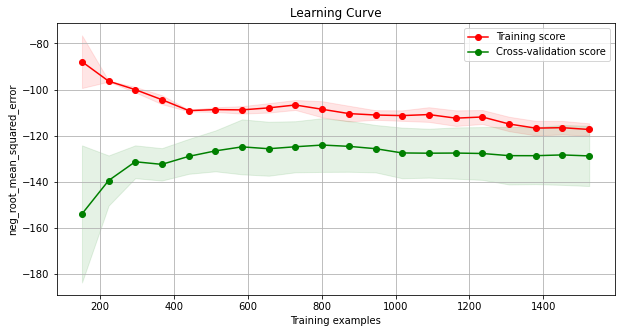

In [38]:
plot_learning_curve(lin_reg, X_train, y_train)

In [40]:
#calculate the predicted values for Test
y_pred = lin_reg.predict(X_predict)

rmse = mean_squared_error(y_predict, y_pred, squared=False)
print("Test Prediction Error (RMSE): {:,.4f}".format(rmse))

Test Prediction Error (RMSE): 384.0854


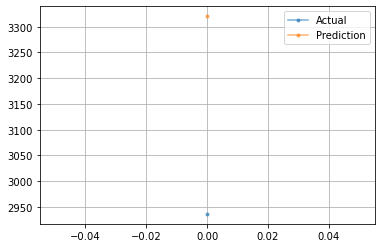

In [41]:
plot_actual_pred(y_predict, y_pred)

In [42]:
y_predict, y_pred

([2936.29826], array([3320.38367553]))

## SGD Regressor

In [43]:
#create a Stocahstic Gradiant Descent Regressor object
model = SGDRegressor(max_iter=1000, tol=.01, penalty="l2", eta0=.001)

#fit the model to the training data
model.fit(X_train, y_train)

#calcualte the predicted values
predictions = model.predict(X_train)

#compare the predicted to the actuals to evaluate the model
rmse = mean_squared_error(y_train,predictions,squared=False)
print("Predition Error (RMSE): {:,.4f}".format(rmse))

Predition Error (RMSE): 176.0754


In [45]:
#calculate the predicted values for Test
y_pred =model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Test Prediction Error (RMSE): {:,.4f}".format(rmse))

Test Prediction Error (RMSE): 173.3889


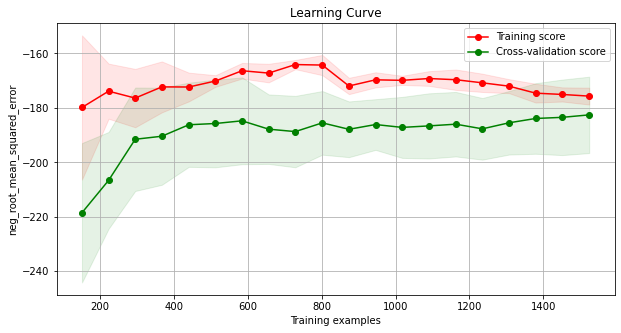

In [44]:
plot_learning_curve(model, X_train, y_train)

In [46]:
#calculate the predicted values for Test
y_pred = model.predict(X_predict)

rmse = mean_squared_error(y_predict, y_pred, squared=False)
print("Test Prediction Error (RMSE): {:,.4f}".format(rmse))

Test Prediction Error (RMSE): 496.9353


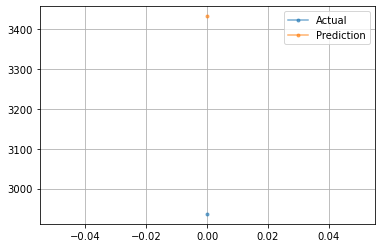

In [47]:
plot_actual_pred(y_predict, y_pred)

In [48]:
y_predict, y_pred

([2936.29826], array([3433.23352936]))

### Decision Tree

In [49]:
#create a Ridge Regression model =
tree_reg=DecisionTreeRegressor()

#fit the model to the training data set
tree_reg.fit(X_train, y_train)

#calculated the predicted values for the training data set
predictions = tree_reg.predict(X_train)

#compare the predicted to the actuals
rmse = mean_squared_error(y_train,predictions, squared=False)
print("Predition Error (RMSE): {:.5f}".format(rmse))

Predition Error (RMSE): 0.00000


In [50]:
#run cross validation
scores = cross_val_score(tree_reg, X_train, y_train, scoring="neg_root_mean_squared_error", cv=10)

#report the results
print("RMSE: {:.5f}".format( -scores.mean() ) )

RMSE: 70.93881


In [51]:
#use the linear regression model and evaluate the test data set
predictions = tree_reg.predict(X_test)

#compare the predicted to the actuals
rmse = mean_squared_error(y_test,predictions, squared=False)
print("Predition Error (RMSE): {:.5f}".format(rmse))

Predition Error (RMSE): 98.86858


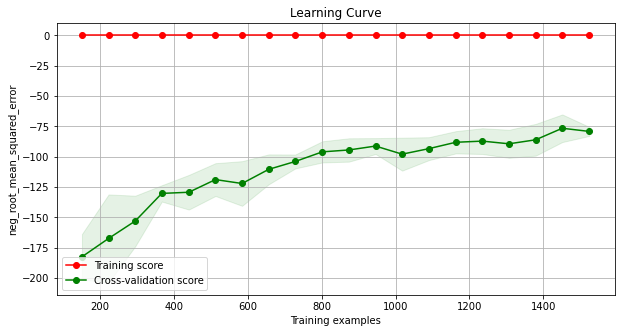

In [52]:
plot_learning_curve(tree_reg, X_train, y_train)

In [54]:
#calculate the predicted values for Test
y_pred = lin_reg.predict(X_predict)

rmse = mean_squared_error(y_predict, y_pred, squared=False)
print("Test Prediction Error (RMSE): {:,.4f}".format(rmse))

Test Prediction Error (RMSE): 384.0854


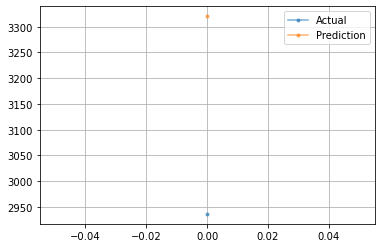

In [55]:
plot_actual_pred(y_predict, y_pred)

## <font color=blue>Linear Regression - 5 Day Prediction

### Save FUTURE data points to predict

In [56]:
FUTURE = 5 #a constant number should be represented with all CAPS

#For demonstrations purposes, keep the predictions aside so you can evaluate the results
toPredict = crypto[-FUTURE:].copy()
y_predict = list(toPredict.Price_ETH)

crypto = crypto[:-FUTURE].copy()

#### Use the columns to create both the test and the training data sets

In [57]:
#split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    crypto.drop(columns=['Price_ETH']), 
    crypto.Price_ETH,
    test_size=0.2,
    random_state=42,
)
X_train.shape,  y_train.shape, X_test.shape,  y_test.shape

((1901, 25), (1901,), (476, 25), (476,))

In [58]:
#no categorical attributes for this data set (nice to have in case data changes)
cat_attribs = []

#set the numerical attributes
num_attribs = list( crypto.drop(columns=['Price_ETH']) )

#define pipeline for numeric attributes (this code is just a definition)
#each numeric attribute will be imputated using the Median strategy
#each numeric attribute will be scaled 
num_pipeline = Pipeline( [
    ('imputer', SimpleImputer(strategy="median")), #because no missing values, not used
    ('std_scaler', StandardScaler()),   
] )

#define the pipeline process for the data set
full_pipeline = ColumnTransformer( [
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(sparse=False), cat_attribs)      #because no categorical attributes, not used 
])

In [59]:
#create an array of prepared data based on the training data set
X_train = full_pipeline.fit_transform( X_train)
X_train.shape

(1901, 25)

In [60]:
#create an array of prepared data based on the test data set
X_test = full_pipeline.transform( X_test)
X_test.shape

(476, 25)

In [61]:
X_predict = full_pipeline.transform( toPredict.drop(columns=["Price_ETH"]) )
X_predict.shape

(5, 25)

## Computing Some Baselines

<font color=blue>Naive Forecasting</font>: just use the last observed value in the series to predict the next value in the series

In [62]:
#calculate the average home value
baseline_prediction = y_train.mean()

#populate an array with the average home value
predictions = np.full(shape=len(X_train), fill_value = baseline_prediction)

#determine the Root Mean Squared Error based on the actual vs. the baseline prediction
baseline_rmse = mean_squared_error(y_train, predictions, squared=False)
print("Baseline temp: {:,.2f}".format(baseline_prediction))
print("Baseline Performance (of this guess): {:,.2f}".format(baseline_rmse))

Baseline temp: 671.21
Baseline Performance (of this guess): 1,082.55


In [63]:
#create a linear regression model
lin_reg=LinearRegression()

#fit the model to the training data set
lin_reg.fit(X_train, y_train)

#calculated the predicted values for the training data set
predictions = lin_reg.predict(X_train)

#compare the predicted to the actuals
rmse = mean_squared_error(y_train,predictions, squared=False)
print("Predition Error (RMSE): {:,.4f}".format(rmse))

Predition Error (RMSE): 116.1120


### Use Cross Validation to Evaluate Model

In [64]:
#run cross validation
scores = cross_val_score(lin_reg,  X_train, y_train, scoring="neg_root_mean_squared_error", cv=10)

#report the results
print("RMSE: {:,.4f}".format( -scores.mean() ) )

RMSE: 125.6745


### Evaluate Model on Test Set

In [65]:
#use the linear regression model and evaluate the test data set
predictions = lin_reg.predict(X_test)

#compare the predicted to the actuals
rmse = mean_squared_error(y_test,predictions, squared=False)
print("Predition Error (RMSE): {:,.4f}".format(rmse))

Predition Error (RMSE): 111.7023


### Review this model's Learning Curve

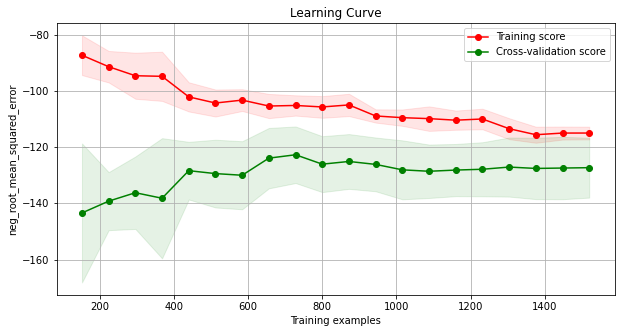

In [66]:
plot_learning_curve(lin_reg, X_train, y_train)

In [68]:
#calculate the predicted values for Test
y_pred = lin_reg.predict(X_predict)

rmse = mean_squared_error(y_predict, y_pred, squared=False)
print("Test Prediction Error (RMSE): {:,.4f}".format(rmse))

Test Prediction Error (RMSE): 443.9098


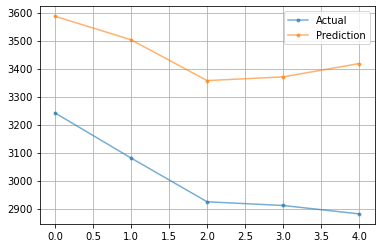

In [69]:
plot_actual_pred(y_predict, y_pred)

### Ridge Model

In [70]:
#create a Ridge Regression model =
ridge_reg=Ridge(alpha=1, solver='auto')

#fit the model to the training data set
ridge_reg.fit(X_train, y_train)

#calculated the predicted values for the training data set
predictions = ridge_reg.predict(X_train)

#compare the predicted to the actuals
rmse = mean_squared_error(y_train,predictions, squared=False)
print("Predition Error (RMSE): {:.5f}".format(rmse))

Predition Error (RMSE): 171.06545


In [71]:
#run cross validation
scores = cross_val_score(ridge_reg, X_train, y_train, scoring="neg_root_mean_squared_error", cv=10)

#report the results
print("RMSE: {:.5f}".format( -scores.mean() ) )

RMSE: 176.66066


In [72]:
#use the linear regression model and evaluate the test data set
predictions = ridge_reg.predict(X_test)

#compare the predicted to the actuals
rmse = mean_squared_error(y_test,predictions, squared=False)
print("Predition Error (RMSE): {:.5f}".format(rmse))

Predition Error (RMSE): 158.23651


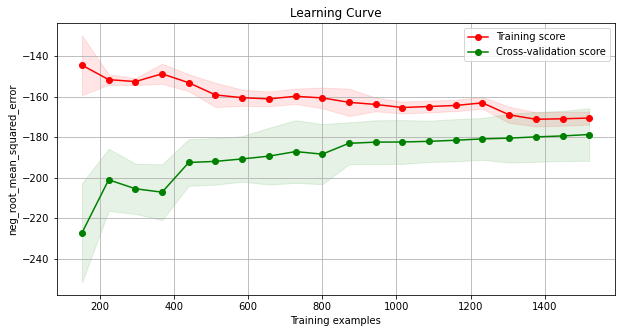

In [73]:
plot_learning_curve(ridge_reg, X_train, y_train)

In [75]:
#calculate the predicted values for Test
y_pred = ridge_reg.predict(X_predict)

rmse = mean_squared_error(y_predict, y_pred, squared=False)
print("Test Prediction Error (RMSE): {:,.4f}".format(rmse))

Test Prediction Error (RMSE): 511.2202


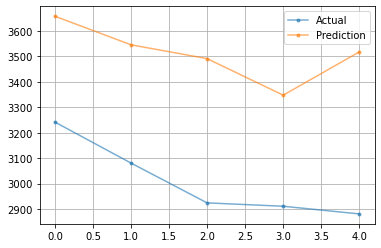

In [76]:
plot_actual_pred(y_predict, y_pred)

### Decision Tree

In [77]:
#create a Ridge Regression model =
tree_reg=DecisionTreeRegressor()

#fit the model to the training data set
tree_reg.fit(X_train, y_train)

#calculated the predicted values for the training data set
predictions = tree_reg.predict(X_train)

#compare the predicted to the actuals
rmse = mean_squared_error(y_train,predictions, squared=False)
print("Predition Error (RMSE): {:.5f}".format(rmse))

Predition Error (RMSE): 0.00000


In [78]:
#run cross validation
scores = cross_val_score(tree_reg, X_train, y_train, scoring="neg_root_mean_squared_error", cv=10)

#report the results
print("RMSE: {:.5f}".format( -scores.mean() ) )

RMSE: 77.01338


In [79]:
#use the linear regression model and evaluate the test data set
predictions = tree_reg.predict(X_test)

#compare the predicted to the actuals
rmse = mean_squared_error(y_test,predictions, squared=False)
print("Predition Error (RMSE): {:.5f}".format(rmse))

Predition Error (RMSE): 81.47360


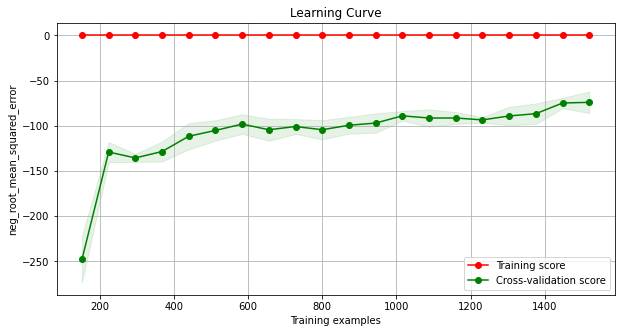

In [80]:
plot_learning_curve(tree_reg, X_train, y_train)

In [94]:
#calculate the predicted values for Test
y_pred = lin_reg.predict(X_predict)

rmse = mean_squared_error(y_predict, y_pred, squared=False)
print("Test Prediction Error (RMSE): {:,.4f}".format(rmse))

Test Prediction Error (RMSE): 443.9098


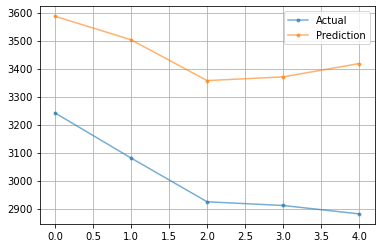

In [83]:
plot_actual_pred(y_predict, y_pred)

### Use Grid Search CV to find the best Hyperparameters

In [84]:
#create a parameter grid that determines the variable hyperparameters
param_grid = [
    {'max_iter': [1000, 2000, 5000], 'eta0': [ .01, .001, .0001],
     'tol': [.0001, .001, .01] },
  ]

# train across 10 folds, that's a total of (2*3*3*2)*10=360 rounds of training 
grid_search = GridSearchCV(SGDRegressor(), param_grid, cv=10,
                           scoring='neg_root_mean_squared_error',
                           return_train_score=True)

#fit the data to the model
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=SGDRegressor(),
             param_grid=[{'eta0': [0.01, 0.001, 0.0001],
                          'max_iter': [1000, 2000, 5000],
                          'tol': [0.0001, 0.001, 0.01]}],
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [85]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print("RMSE: {:,.4f} - {}".format( -mean_score, params) )

RMSE: 180.0246 - {'eta0': 0.01, 'max_iter': 1000, 'tol': 0.0001}
RMSE: 180.7572 - {'eta0': 0.01, 'max_iter': 1000, 'tol': 0.001}
RMSE: 182.0060 - {'eta0': 0.01, 'max_iter': 1000, 'tol': 0.01}
RMSE: 181.4871 - {'eta0': 0.01, 'max_iter': 2000, 'tol': 0.0001}
RMSE: 179.1222 - {'eta0': 0.01, 'max_iter': 2000, 'tol': 0.001}
RMSE: 182.5924 - {'eta0': 0.01, 'max_iter': 2000, 'tol': 0.01}
RMSE: 183.3628 - {'eta0': 0.01, 'max_iter': 5000, 'tol': 0.0001}
RMSE: 182.0052 - {'eta0': 0.01, 'max_iter': 5000, 'tol': 0.001}
RMSE: 182.8838 - {'eta0': 0.01, 'max_iter': 5000, 'tol': 0.01}
RMSE: 182.4891 - {'eta0': 0.001, 'max_iter': 1000, 'tol': 0.0001}
RMSE: 182.1945 - {'eta0': 0.001, 'max_iter': 1000, 'tol': 0.001}
RMSE: 182.1998 - {'eta0': 0.001, 'max_iter': 1000, 'tol': 0.01}
RMSE: 181.5108 - {'eta0': 0.001, 'max_iter': 2000, 'tol': 0.0001}
RMSE: 181.4487 - {'eta0': 0.001, 'max_iter': 2000, 'tol': 0.001}
RMSE: 181.6434 - {'eta0': 0.001, 'max_iter': 2000, 'tol': 0.01}
RMSE: 181.7119 - {'eta0': 0.001, '

In [86]:
grid_search.best_params_

{'eta0': 0.01, 'max_iter': 2000, 'tol': 0.001}

### Evaluate Best Model

In [87]:
sgd_model = SGDRegressor(**grid_search.best_params_)
sgd_model.fit(X_train, y_train)

#calcualte the predicted values
predictions = sgd_model.predict(X_train)

#compare the predicted (housing_predictions) to the actuals(housing_labels)
rmse = mean_squared_error( y_train, predictions,squared=False)
print("Predition Error (RMSE): {:,.4f}".format(rmse))

Predition Error (RMSE): 176.5119


In [88]:
#run cross validation
scores = cross_val_score(sgd_model, X_train, y_train, scoring="neg_root_mean_squared_error", cv=10)

#report the results
print("RMSE: {:,.4f}".format( -scores.mean() ) )

RMSE: 182.7423


### Evaluate Best Model on Test Set

In [89]:
#calcualte the predicted values
predictions = sgd_model.predict(X_test)

#compare the predicted (housing_predictions) to the actuals(housing_labels)
rmse = mean_squared_error( y_test, predictions,squared=False)
print("Predition Error (RMSE): {:,.4f}".format(rmse))

Predition Error (RMSE): 164.2857


## Plot Learning Curve

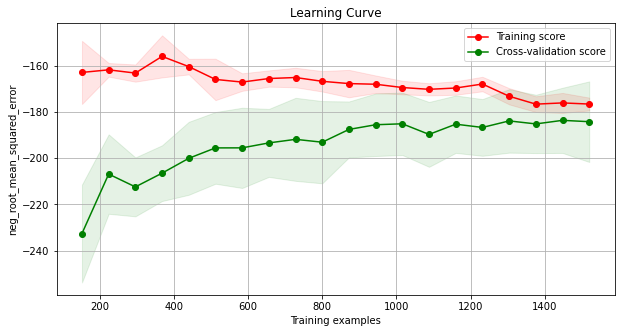

In [90]:
plot_learning_curve(sgd_model,X_train,y_train)

In [92]:
#calculate the predicted values for Test
y_pred = sgd_model.predict(X_predict)

rmse = mean_squared_error(y_predict, y_pred, squared=False)
print("Test Prediction Error (RMSE): {:,.4f}".format(rmse))

Test Prediction Error (RMSE): 500.2726


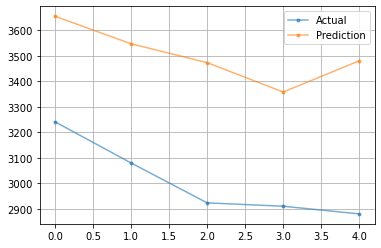

In [93]:
plot_actual_pred(y_predict, y_pred)

## Neural Network Data Prep

#### This code assumes that the data is in chronological order (i.e. ascending).

In [100]:
crypto.drop(columns="Year", inplace=True)
crypto.drop(columns="Month", inplace=True)
crypto.drop(columns="Day", inplace= True)

In [101]:
#scale the data using MinMaxScaler
#challenge here is that we need to preserve the scaler used on the labeled data for future predictions

#scaler used for X features
xScaler = MinMaxScaler()
xScaled = xScaler.fit_transform(crypto.drop(columns=['Price_ETH']))

#scaler for Y feature
yScaler = MinMaxScaler()
yScaled = yScaler.fit_transform(crypto[['Price_ETH']])


#let's se what we now have
xScaled.shape, yScaled.shape

((2377, 22), (2377, 1))

In [102]:
#NOTE that we want to include Y as part of X to use it to predisct the next Y
scaled_data = np.concatenate( [ yScaled, xScaled], axis=1)
scaled_data.shape

(2377, 23)

In [103]:
#added during class
scaled_data[0:5]

array([[1.62135258e-04, 9.04813292e-04, 1.47542221e-04, 0.00000000e+00,
        0.00000000e+00, 7.35103302e-04, 3.12342987e-02, 5.53706524e-04,
        1.17849650e-03, 4.17154653e-04, 0.00000000e+00, 3.25432718e-03,
        6.09891278e-03, 1.93130855e-03, 1.78617803e-03, 9.43724194e-04,
        0.00000000e+00, 6.54649272e-05, 5.72129077e-02, 4.95270382e-05,
        2.20105708e-05, 7.32102261e-04, 0.00000000e+00],
       [1.62135258e-04, 0.00000000e+00, 1.09556161e-05, 5.01599918e-06,
        5.98665543e-04, 8.07756792e-04, 0.00000000e+00, 6.10150640e-04,
        3.82356222e-03, 1.93574821e-04, 7.92954274e-04, 3.38430764e-03,
        4.95875995e-03, 2.01507152e-03, 2.12547762e-03, 7.64415062e-04,
        9.77600120e-04, 7.66058441e-05, 7.24318102e-02, 5.82034400e-05,
        1.98392602e-05, 5.97058003e-04, 3.97955123e-04],
       [1.62135258e-04, 4.12762765e-04, 1.56360362e-05, 1.58119083e-05,
        1.21140789e-03, 7.86767641e-04, 6.77661842e-02, 5.94925258e-04,
        7.43009115e-04

In [104]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#The samples are the number of rows. Timestep is how many previous predictions are to be used to calculate future predictions.
#Features is simply the number of columns/features in the training dataset.

FEATURES = scaled_data.shape[1]  #the number of features/dimensions in the data set
STEPS =  10        #Should be 10               #the timestep used to predict   #use the past 5 days to predict 1 day in the future
FUTURE = 1        #Should be 5               #how many days in the future to predict

#steps should be greater than or equal to future

In [105]:
#Empty lists to be populated using formatted training data
trainX = []
trainY = []

#Reformat input data into a shape: (n_samples x timesteps x features)
for i in range(STEPS, len(scaled_data) - FUTURE + 1):
    trainX.append(scaled_data[i - STEPS     :i         , 0:scaled_data.shape[1] ] )
    trainY.append(scaled_data[i + FUTURE - 1:i + FUTURE, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

trainX.shape, trainY.shape

((2367, 10, 23), (2367, 1))

In [106]:
#added from class
trainX[0]

array([[1.62135258e-04, 9.04813292e-04, 1.47542221e-04, 0.00000000e+00,
        0.00000000e+00, 7.35103302e-04, 3.12342987e-02, 5.53706524e-04,
        1.17849650e-03, 4.17154653e-04, 0.00000000e+00, 3.25432718e-03,
        6.09891278e-03, 1.93130855e-03, 1.78617803e-03, 9.43724194e-04,
        0.00000000e+00, 6.54649272e-05, 5.72129077e-02, 4.95270382e-05,
        2.20105708e-05, 7.32102261e-04, 0.00000000e+00],
       [1.62135258e-04, 0.00000000e+00, 1.09556161e-05, 5.01599918e-06,
        5.98665543e-04, 8.07756792e-04, 0.00000000e+00, 6.10150640e-04,
        3.82356222e-03, 1.93574821e-04, 7.92954274e-04, 3.38430764e-03,
        4.95875995e-03, 2.01507152e-03, 2.12547762e-03, 7.64415062e-04,
        9.77600120e-04, 7.66058441e-05, 7.24318102e-02, 5.82034400e-05,
        1.98392602e-05, 5.97058003e-04, 3.97955123e-04],
       [1.62135258e-04, 4.12762765e-04, 1.56360362e-05, 1.58119083e-05,
        1.21140789e-03, 7.86767641e-04, 6.77661842e-02, 5.94925258e-04,
        7.43009115e-04

In [107]:
#added from class
trainY[0]

array([0.00013806])

### Save FUTURE data points to predict

In [108]:
#For demonstrations purposes, keep the predictions aside so you can evaluate the results
toPredict = trainX[-FUTURE:].copy()
prediction = trainY[-FUTURE:].copy()
prediction = yScaler.inverse_transform( prediction )

#remove future predictions from dataset
trainX = trainX[:-FUTURE].copy()
trainY = trainY[:-FUTURE].copy()

trainX.shape, trainY.shape, toPredict.shape, prediction.shape
#726 rows, 5 by 6 (its going to learn from 5 sets of 6 features, 5 sequential examples that has 6 features)

((2366, 10, 23), (2366, 1), (1, 10, 23), (1, 1))

#### Create Test by splitting the training data sets

In [109]:
#split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(trainX, 
                                                    trainY, 
                                                    test_size=0.2, 
                                                    shuffle = False)
X_train.shape,  y_train.shape, X_test.shape,  y_test.shape

((1892, 10, 23), (1892, 1), (474, 10, 23), (474, 1))

In [110]:
#explore what a single time series looks likes (at least just the first 3 entries)
for i in range(3):
    print('{:} => {:}'.format(X_train[i], y_train[i]) )

[[1.62135258e-04 9.04813292e-04 1.47542221e-04 0.00000000e+00
  0.00000000e+00 7.35103302e-04 3.12342987e-02 5.53706524e-04
  1.17849650e-03 4.17154653e-04 0.00000000e+00 3.25432718e-03
  6.09891278e-03 1.93130855e-03 1.78617803e-03 9.43724194e-04
  0.00000000e+00 6.54649272e-05 5.72129077e-02 4.95270382e-05
  2.20105708e-05 7.32102261e-04 0.00000000e+00]
 [1.62135258e-04 0.00000000e+00 1.09556161e-05 5.01599918e-06
  5.98665543e-04 8.07756792e-04 0.00000000e+00 6.10150640e-04
  3.82356222e-03 1.93574821e-04 7.92954274e-04 3.38430764e-03
  4.95875995e-03 2.01507152e-03 2.12547762e-03 7.64415062e-04
  9.77600120e-04 7.66058441e-05 7.24318102e-02 5.82034400e-05
  1.98392602e-05 5.97058003e-04 3.97955123e-04]
 [1.62135258e-04 4.12762765e-04 1.56360362e-05 1.58119083e-05
  1.21140789e-03 7.86767641e-04 6.77661842e-02 5.94925258e-04
  7.43009115e-04 4.96035479e-04 1.72551317e-03 3.44216503e-03
  6.64184270e-03 2.05481085e-03 1.88076562e-03 8.04262227e-04
  1.97834924e-03 7.25297921e-05 6.37

## Computing Some Baselines

<font color=blue>Naive Forecasting</font>: just use the last observed value in the series to predict the next value in the series

In [111]:
#predcition is based on last observed value
pred= yScaler.inverse_transform( y_test[:-1] )
actual= yScaler.inverse_transform( y_test[1:] )

#calculate the Mean Squared Error between the prediction and the actual
naive = mean_squared_error(pred, actual, squared=False)
print( 'Naive ERROR: {:.4f}'.format(naive) )

Naive ERROR: 133.8220


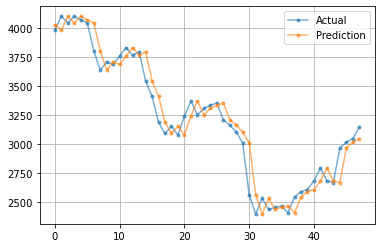

In [112]:
#plot the last 48 instances in the series to see the "predicted" shift in temperatures 
plot_actual_pred (actual[-48:], pred[-48:])

## Linear predictions using a Neural Network

In [113]:
#starting by setting random seeds and restarting keras blackend session
np.random.seed(42)
tf.random.set_seed(42)

#resets the Keras global state - helps avoid clutter from old models and layers, especially when memory is limited
keras.backend.clear_session()

In [114]:
#define early stopping
#this is not necessary BUT helps models run faster
#define what early stopping means - in this case, when the validation loss after 2 iterations hasn't changed
#after defining, it can be added to any model fitting using the parameter callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", 
                                               patience=40,
                                              # verbose =1,
                                              # baseline = .05,
                                               mode='min')

In [1009]:
#create a simple linear neural network
model = keras.models.Sequential([
   # keras.layers.LSTM(50, return_sequences=True, input_shape=[None, FEATURES]),
    keras.layers.LSTM(50, return_sequences=True, input_shape=[None, FEATURES]),
    keras.layers.Dropout(.2),
    keras.layers.LSTM(50),  #before it was just 20
    keras.layers.Dense(FUTURE)
])

In [1010]:
#compile and fit the model
#note we are using the metric Mean Squared Error for tempertatures
model.compile(loss="mean_squared_error", 
              optimizer=keras.optimizers.Adam(learning_rate=0.00033), 
             )

In [1011]:
#fit the model 
#NOTE: Because we are workign with a continuous series, shuffle=False is needed
history = model.fit(X_train, y_train, 
                    epochs=500, 
                    batch_size=STEPS,
                    validation_split=.2, 
                    shuffle=False, 
                    #Order matters so it cannot be random
                    callbacks=[early_stopping])

Epoch 1/500
152/152 [==============================] - 10s 26ms/step - loss: 0.0014 - val_loss: 4.9458e-04
Epoch 2/500
152/152 [==============================] - 2s 16ms/step - loss: 8.9087e-04 - val_loss: 0.0018
Epoch 3/500
152/152 [==============================] - 2s 15ms/step - loss: 8.4523e-04 - val_loss: 0.0029
Epoch 4/500
152/152 [==============================] - 2s 14ms/step - loss: 9.4017e-04 - val_loss: 0.0024
Epoch 5/500
152/152 [==============================] - 2s 14ms/step - loss: 6.8747e-04 - val_loss: 0.0011
Epoch 6/500
152/152 [==============================] - 2s 15ms/step - loss: 4.2742e-04 - val_loss: 3.3105e-04
Epoch 7/500
152/152 [==============================] - 2s 14ms/step - loss: 3.0874e-04 - val_loss: 1.5979e-04
Epoch 8/500
152/152 [==============================] - 2s 14ms/step - loss: 2.3439e-04 - val_loss: 2.0755e-04
Epoch 9/500
152/152 [==============================] - 2s 15ms/step - loss: 2.0958e-04 - val_loss: 1.6944e-04
Epoch 10/500
152/152 [=======

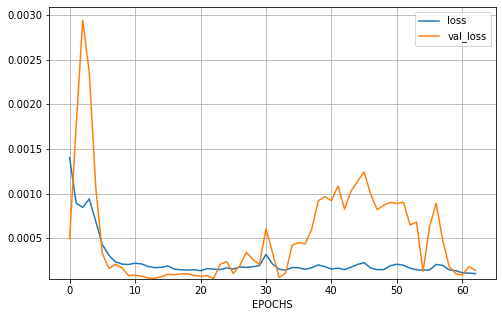

In [1012]:
#see that the learning curve is healthy
nn_plot_learning_curve( history )

In [1013]:
#predict the training data set
y_pred = model.predict(X_train)

#scale predicted and actuals
pred = yScaler.inverse_transform( y_pred )
actual = yScaler.inverse_transform( y_train )

#calculate the Mean Squared Error using the scaled values
error = mean_squared_error(pred, actual, squared=False)
print( 'ERROR: {:.4f}'.format(error) )

ERROR: 68.1114


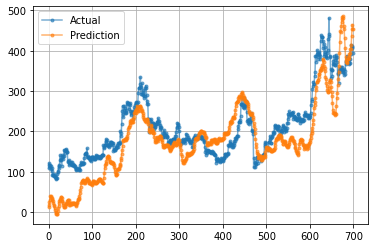

In [1014]:
#plot the actuals vs. the predictions
plot_actual_pred ( actual[-700:], pred[-700:] )

In [1015]:
#predict the test data
y_pred = model.predict(X_test)

#scale predicted and actuals
pred = yScaler.inverse_transform( y_pred )
actual = yScaler.inverse_transform( y_test )

#calculate the Mean Squared Error using the scaled values
error = mean_squared_error(pred, actual, squared=False)
print( 'ERROR: {:.4f}'.format(error) )


ERROR: 373.8306


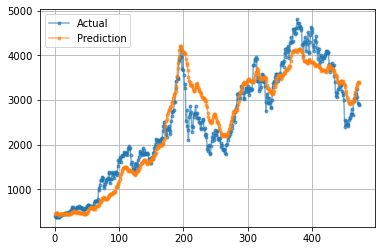

In [1016]:
#plot the actuals vs. the predictions
plot_actual_pred ( actual[-500:], pred[-500:] )

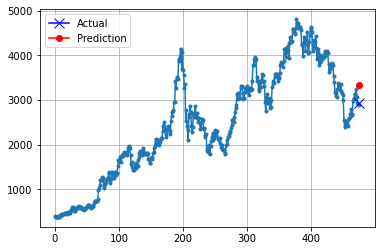

In [1017]:
#Predict using the model
y_prediction = model.predict( toPredict )

#scale the y values
y_prediction = yScaler.inverse_transform( y_prediction )

#plot the actual values as well as future known actuals vs. future predictions
#NOTE: if FUTURES is > 1, the ,0 is needed to only plot the 1st value in the prediction
plot_series(actual[-500:], prediction, y_prediction[:,0]) 

In [1018]:
#print the error
#lr=.00033 neurons: 50, 50, and LSTM (change random seed back to 42, patience = 10)
mean_squared_error( y_prediction[:,0], prediction, squared=False) 

401.0435368749995

In [513]:
#print the error
#lr=.00033 neurons: 65 and LSTM (change random seed back to 42, patience = 15)
mean_squared_error( y_prediction[:,0], prediction, squared=False) 

623.6871760156255

In [488]:
#print the error
#lr=.00033 neurons: 65 and LSTM (change random seed back to 42, patience = 15)
mean_squared_error( y_prediction[:,0], prediction, squared=False) 

1946.823772695313

In [475]:
#print the error
#lr=.00033 neurons: 70 and LSTM (change random seed back to 42, patience = 15)
mean_squared_error( y_prediction[:,0], prediction, squared=False) 

1095.4403498437505

In [463]:
#print the error
#lr=.00033 neurons: 60 and LSTM (change random seed back to 42, patience = 15)
mean_squared_error( y_prediction[:,0], prediction, squared=False) 

104.49039867187548

In [451]:
#print the error
#lr=.00033 neurons: 50 and LSTM (change random seed back to 42, patience = 25)
mean_squared_error( y_prediction[:,0], prediction, squared=False) 

137.03336742187548

In [439]:
#print the error
#lr=.00033 neurons: 50 and LSTM (change random seed back to 42, patience = 35)
mean_squared_error( y_prediction[:,0], prediction, squared=False) 

248.13029125000048

In [427]:
#print the error
#lr=.00033 neurons: 45 and LSTM (change random seed back to 42, patience = 200)
mean_squared_error( y_prediction[:,0], prediction, squared=False) 

599.8168146875005

In [415]:
#print the error
#lr=.00033 neurons: 50, 45, 45 and LSTM (change random seed back to 42, patience = 200)
mean_squared_error( y_prediction[:,0], prediction, squared=False) 

1088.333050039063

In [392]:
#print the error
#lr=.00033 neurons: 45, 40, 35 and LSTM (change random seed back to 42, patience = 200)
mean_squared_error( y_prediction[:,0], prediction, squared=False) 

599.8382990625005

In [392]:
#print the error
#lr=.00033 neurons: 40,40 and LSTM (change random seed back to 42, patience = 200)
mean_squared_error( y_prediction[:,0], prediction, squared=False) 

599.8382990625005

In [349]:
#print the error
#lr=.00033 neurons: 50, 50, 35 and LSTM (change random seed back to 42, patience = 200)
mean_squared_error( y_prediction[:,0], prediction, squared=False) 

781.2025568750005

In [313]:
#print the error
#lr=.00033 neurons: 50, 50, 25 and LSTM (change random seed back to 42, patience = 200)
mean_squared_error( y_prediction[:,0], prediction, squared=False) 

791.2457697656255

In [301]:
#print the error
#lr=.00033 neurons: 50, 50, and LSTM (change random seed back to 42, patience = 100)
mean_squared_error( y_prediction[:,0], prediction, squared=False) 

1337.246380117188

In [289]:
#print the error
#lr=.00033 neurons: 50, 50 and LSTM (change random seed to 2, patience = 50)
mean_squared_error( y_prediction[:,0], prediction, squared=False) 

779.0358088281255

In [277]:
#print the error
#lr=.00033 neurons: 150, 100, and LSTM (change random seed back to 42, patience = 10)
mean_squared_error( y_prediction[:,0], prediction, squared=False) 

2615.197277333985

In [173]:
#print the error
#lr=.00033 neurons: 100, 50, and LSTM (change random seed back to 42, patience = 10)
mean_squared_error( y_prediction[:,0], prediction, squared=False) 

1206.5089533593755

In [161]:
#print the error
#lr=.00033 neurons: 100, 100, and LSTM (change random seed back to 42, patience = 10)
mean_squared_error( y_prediction[:,0], prediction, squared=False) 

1459.0760920312505

In [149]:
#print the error
#lr=.00033 neurons: 50, 50, and LSTM (change random seed back to 45, patience = 10)
mean_squared_error( y_prediction[:,0], prediction, squared=False) 

749.7843439843755

In [136]:
#print the error
#lr=.00033 neurons: 50, 50, and LSTM (change random seed back to 42, patience = 7)
mean_squared_error( y_prediction[:,0], prediction, squared=False) 

515.2340510156255

In [123]:
#print the error
#lr=.00033 neurons: 50, 50, and LSTM (change random seed back to 42, patience = 25)
mean_squared_error( y_prediction[:,0], prediction, squared=False) 

75.88615062500048

In [ ]:
#print the error
#lr=.00033 neurons: 50, 50, and LSTM (patience = 15) (change random seed back to 42, patience = 45)
mean_squared_error( y_prediction[:,0], prediction, squared=False) 

742.5253107812505

In [99]:
#print the error
#lr=.00033 neurons: 50, 50, and LSTM (patience = 15) (change random seed back to 42, patience = 25)
mean_squared_error( y_prediction[:,0], prediction, squared=False) 

35.56388500000048

In [87]:
#print the error
#lr=.00033 neurons: 50, 50, and LSTM (patience = 15) (change random seed back to 42)
mean_squared_error( y_prediction[:,0], prediction, squared=False) 

210.68717601562548

In [75]:
#print the error
#lr=.00033 neurons: 50, 50, and LSTM (patience = 15) (change random seed to 43)
mean_squared_error( y_prediction[:,0], prediction, squared=False) 

1539.860637929688

In [701]:
#print the error
#lr=.00033 neurons: 50, 50, and LSTM (patience = 15) (change random seed back to 42)
mean_squared_error( y_prediction[:,0], prediction, squared=False) 

210.68717601562548

In [676]:
#print the error
#lr=.00033 neurons: 53, 53, and LSTM (patience = 15) (change random seed back to 42)
mean_squared_error( y_prediction[:,0], prediction, squared=False) 

884.8146174218755

In [664]:
#print the error
#lr=.00033 neurons: 56, 56, and LSTM (patience = 15) (change random seed back to 42)
mean_squared_error( y_prediction[:,0], prediction, squared=False) 

876.4464533593755

In [652]:
#print the error
#lr=.00033 neurons: 57, 57, and LSTM (patience = 15) (change random seed back to 42)
mean_squared_error( y_prediction[:,0], prediction, squared=False) 

532.3680842187505

In [640]:
#print the error
#lr=.00033 neurons: 55, 55, and LSTM (patience = 15) (change random seed back to 42)
mean_squared_error( y_prediction[:,0], prediction, squared=False) 

503.5094416406255

In [616]:
#print the error
#lr=.00033 neurons: 70, 70, and LSTM (patience = 15) (change random seed back to 42)
mean_squared_error( y_prediction[:,0], prediction, squared=False) 

1213.9515803125005

In [592]:
#print the error
#lr=.00033 neurons: 80, 80, and LSTM (patience = 15) (change random seed back to 42)
mean_squared_error( y_prediction[:,0], prediction, squared=False) 

771.6407892968755

In [567]:
#print the error
#lr=.00033 neurons: 60, 60, and LSTM (patience = 15) (change random seed back to 42)
mean_squared_error( y_prediction[:,0], prediction, squared=False) 

505.8824885156255

In [542]:
#print the error
#lr=.00033 neurons: 45, 45, and LSTM (patience = 15) (change random seed back to 42)
mean_squared_error( y_prediction[:,0], prediction, squared=False) 

1178.7889826562505

In [555]:
#print the error
#lr=.00033 neurons: 45, 45, 45, and LSTM (patience = 15) (change random seed back to 42)
mean_squared_error( y_prediction[:,0], prediction, squared=False) 

871.9025080468755

In [518]:
#print the error
#lr=.00033 neurons: 50, 50, and LSTM (patience = 15) (change random seed back to 42)
mean_squared_error( y_prediction[:,0], prediction, squared=False) 

75.88615062500048

In [506]:
#print the error
#lr=.00033 neurons: 40, 40, and LSTM (patience = 15) (change random seed back to 42)
mean_squared_error( y_prediction[:,0], prediction, squared=False) 

455.9847834375005

In [494]:
#print the error
#lr=.00033 neurons: 30, 30, and LSTM (patience = 15) (change random seed back to 42)
mean_squared_error( y_prediction[:,0], prediction, squared=False) 

738.0941584375005

In [482]:
#print the error
#lr=.00033 neurons: 20, 20, and LSTM (patience = 15) (change random seed back to 42)
mean_squared_error( y_prediction[:,0], prediction, squared=False) 

886.6027033593755

In [470]:
#print the error
#lr=.00033 neurons: 23, 20, 20, and LSTM (patience = 15) (change random seed back to 42)
mean_squared_error( y_prediction[:,0], prediction, squared=False) 

967.950725820313

In [458]:
#print the error
#lr=.00033 neurons: 23, 20, 10, and LSTM (patience = 15) (change random seed back to 42)
mean_squared_error( y_prediction[:,0], prediction, squared=False) 

1426.539593007813

In [446]:
#print the error
#lr=.00033 neurons: 20, 20, 20, and LSTM (patience = 15) (change random seed to 35)
mean_squared_error( y_prediction[:,0], prediction, squared=False) 

765.2672541406255

In [434]:
#print the error
#lr=.00033 neurons: 20, 20, 20, and LSTM (patience = 15) (change random seed to 41)
mean_squared_error( y_prediction[:,0], prediction, squared=False) 

659.0863459375005

In [422]:
#print the error
#lr=.00033 neurons: 20, 20, 20, and LSTM (patience = 15) (change random seed back to 42)
mean_squared_error( y_prediction[:,0], prediction, squared=False) 

801.7076838281255

In [410]:
#print the error
#lr=.00033 neurons: 20, 20, 20, and LSTM (patience = 15) (change random seed to 4)
mean_squared_error( y_prediction[:,0], prediction, squared=False) 

1785.147991445313

In [398]:
#print the error
#lr=.00033 neurons: 20, 20, 20, and GRU (patience = 15)
mean_squared_error( y_prediction[:,0], prediction, squared=False) 

1773.8578303125005

In [386]:
#print the error
#lr=.00033 neurons: 20, 20, 20, 20 and LSTM (patience = 15)
mean_squared_error( y_prediction[:,0], prediction, squared=False) 

1978.356731679688

In [374]:
#print the error
#lr=.00033 neurons: 20, 20, 20 and LSTM (patience = 15)
mean_squared_error( y_prediction[:,0], prediction, squared=False) 

801.7076838281255

In [362]:
#print the error
#lr=.00033 neurons: 10, 10, 10 and LSTM (patience = 15)
mean_squared_error( y_prediction[:,0], prediction, squared=False) 

1738.8541682031255

In [350]:
#print the error
#lr=.00033 neurons: 20, 20, 20, 10 and LSTM (patience = 15)
mean_squared_error( y_prediction[:,0], prediction, squared=False) 

1678.3419611718755

In [338]:
#print the error
#lr=.00033 neurons: 20, 20, 20, 10 and LSTM (patience = 25)
mean_squared_error( y_prediction[:,0], prediction, squared=False) 

1658.996380117188

In [ ]:
#print the error
#lr=.00033 neurons: 20, 20, 10 and LSTM (patience = 15)
mean_squared_error( y_prediction[:,0], prediction, squared=False) 

962.8087580468755

In [ ]:
#print the error
#lr=.00033 neurons: 20, 10 and LSTM (patience = 5 for all previous runs)
mean_squared_error( y_prediction[:,0], prediction, squared=False) 

1672.240520742188

In [ ]:
#print the error
#lr=.00033 neurons: 20, 10 and GRU
mean_squared_error( y_prediction[:,0], prediction, squared=False) 

1660.0836603906255

In [ ]:
#print the error
#lr=.00033 neurons: 30, 4
mean_squared_error( y_prediction[:,0], prediction, squared=False) 

1864.920696523438

In [ ]:
#print the error
#lr=.00033 neurons: 23, 17, 4
mean_squared_error( y_prediction[:,0], prediction, squared=False) 

1935.566936757813

In [ ]:
#print the error
#lr=.00033 neurons: 17 and 10
mean_squared_error( y_prediction[:,0], prediction, squared=False) 

1574.828899648438

In [ ]:
#print the error
#lr=.00033 neurons: 20
mean_squared_error( y_prediction[:,0], prediction, squared=False) 

1152.142376210938

In [ ]:
#print the error
#lr=.00032
mean_squared_error( y_prediction[:,0], prediction, squared=False) 

1841.555462148438

In [ ]:
#print the error
#lr=.00034
mean_squared_error( y_prediction[:,0], prediction, squared=False) 

1158.312298085938

In [ ]:
#print the error
#lr=.00036
mean_squared_error( y_prediction[:,0], prediction, squared=False) 

1172.9293635156255

In [ ]:
#print the error
#lr=.00038
mean_squared_error( y_prediction[:,0], prediction, squared=False) 

1191.555706289063

In [ ]:
#print the error
#lr=.00047
mean_squared_error( y_prediction[:,0], prediction, squared=False) 

1290.710491445313

In [ ]:
#print the error
#lr =.00045
mean_squared_error( y_prediction[:,0], prediction, squared=False) 

1272.2255060937505

In [ ]:
#print the error
#lr =.0004
mean_squared_error( y_prediction[:,0], prediction, squared=False) 

1215.568889882813

In [ ]:
#print the error
#lr=.0005
mean_squared_error( y_prediction[:,0], prediction, squared=False) 

1382.1302912500005

# 5 Day Prediction

In [115]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#The samples are the number of rows. Timestep is how many previous predictions are to be used to calculate future predictions.
#Features is simply the number of columns/features in the training dataset.

FEATURES = scaled_data.shape[1]  #the number of features/dimensions in the data set
STEPS =  10        #Should be 10               #the timestep used to predict   #use the past 5 days to predict 1 day in the future
FUTURE = 5       #Should be 5               #how many days in the future to predict

#steps should be greater than or equal to future

In [116]:
#Empty lists to be populated using formatted training data
trainX = []
trainY = []

#Reformat input data into a shape: (n_samples x timesteps x features)
for i in range(STEPS, len(scaled_data) - FUTURE + 1):
    trainX.append(scaled_data[i - STEPS     :i         , 0:scaled_data.shape[1] ] )
    trainY.append(scaled_data[i + FUTURE - 1:i + FUTURE, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

trainX.shape, trainY.shape

((2363, 10, 23), (2363, 1))

In [117]:
#added from class
trainX[0]

array([[1.62135258e-04, 9.04813292e-04, 1.47542221e-04, 0.00000000e+00,
        0.00000000e+00, 7.35103302e-04, 3.12342987e-02, 5.53706524e-04,
        1.17849650e-03, 4.17154653e-04, 0.00000000e+00, 3.25432718e-03,
        6.09891278e-03, 1.93130855e-03, 1.78617803e-03, 9.43724194e-04,
        0.00000000e+00, 6.54649272e-05, 5.72129077e-02, 4.95270382e-05,
        2.20105708e-05, 7.32102261e-04, 0.00000000e+00],
       [1.62135258e-04, 0.00000000e+00, 1.09556161e-05, 5.01599918e-06,
        5.98665543e-04, 8.07756792e-04, 0.00000000e+00, 6.10150640e-04,
        3.82356222e-03, 1.93574821e-04, 7.92954274e-04, 3.38430764e-03,
        4.95875995e-03, 2.01507152e-03, 2.12547762e-03, 7.64415062e-04,
        9.77600120e-04, 7.66058441e-05, 7.24318102e-02, 5.82034400e-05,
        1.98392602e-05, 5.97058003e-04, 3.97955123e-04],
       [1.62135258e-04, 4.12762765e-04, 1.56360362e-05, 1.58119083e-05,
        1.21140789e-03, 7.86767641e-04, 6.77661842e-02, 5.94925258e-04,
        7.43009115e-04

In [118]:
#added from class
trainY[0]

array([0.00020371])

### Save FUTURE data points to predict

In [119]:
#For demonstrations purposes, keep the predictions aside so you can evaluate the results
toPredict = trainX[-FUTURE:].copy()
prediction = trainY[-FUTURE:].copy()
prediction = yScaler.inverse_transform( prediction )

#remove future predictions from dataset
trainX = trainX[:-FUTURE].copy()
trainY = trainY[:-FUTURE].copy()

trainX.shape, trainY.shape, toPredict.shape, prediction.shape
#726 rows, 5 by 6 (its going to learn from 5 sets of 6 features, 5 sequential examples that has 6 features)

((2358, 10, 23), (2358, 1), (5, 10, 23), (5, 1))

#### Create Test by splitting the training data sets

In [120]:
#split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(trainX, 
                                                    trainY, 
                                                    test_size=0.2, 
                                                    shuffle = False)
X_train.shape,  y_train.shape, X_test.shape,  y_test.shape

((1886, 10, 23), (1886, 1), (472, 10, 23), (472, 1))

In [121]:
#explore what a single time series looks likes (at least just the first 3 entries)
for i in range(3):
    print('{:} => {:}'.format(X_train[i], y_train[i]) )

[[1.62135258e-04 9.04813292e-04 1.47542221e-04 0.00000000e+00
  0.00000000e+00 7.35103302e-04 3.12342987e-02 5.53706524e-04
  1.17849650e-03 4.17154653e-04 0.00000000e+00 3.25432718e-03
  6.09891278e-03 1.93130855e-03 1.78617803e-03 9.43724194e-04
  0.00000000e+00 6.54649272e-05 5.72129077e-02 4.95270382e-05
  2.20105708e-05 7.32102261e-04 0.00000000e+00]
 [1.62135258e-04 0.00000000e+00 1.09556161e-05 5.01599918e-06
  5.98665543e-04 8.07756792e-04 0.00000000e+00 6.10150640e-04
  3.82356222e-03 1.93574821e-04 7.92954274e-04 3.38430764e-03
  4.95875995e-03 2.01507152e-03 2.12547762e-03 7.64415062e-04
  9.77600120e-04 7.66058441e-05 7.24318102e-02 5.82034400e-05
  1.98392602e-05 5.97058003e-04 3.97955123e-04]
 [1.62135258e-04 4.12762765e-04 1.56360362e-05 1.58119083e-05
  1.21140789e-03 7.86767641e-04 6.77661842e-02 5.94925258e-04
  7.43009115e-04 4.96035479e-04 1.72551317e-03 3.44216503e-03
  6.64184270e-03 2.05481085e-03 1.88076562e-03 8.04262227e-04
  1.97834924e-03 7.25297921e-05 6.37

## Computing Some Baselines

<font color=blue>Naive Forecasting</font>: just use the last observed value in the series to predict the next value in the series

In [122]:
#predcition is based on last observed value
pred= yScaler.inverse_transform( y_test[:-1] )
actual= yScaler.inverse_transform( y_test[1:] )

#calculate the Mean Squared Error between the prediction and the actual
naive = mean_squared_error(pred, actual, squared=False)
print( 'Naive ERROR: {:.4f}'.format(naive) )

Naive ERROR: 133.3037


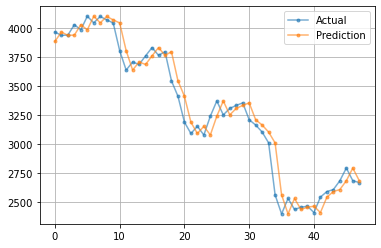

In [123]:
#plot the last 48 instances in the series to see the "predicted" shift in temperatures 
plot_actual_pred (actual[-48:], pred[-48:])

## Run 5 Day Prediction Model

In [163]:
#starting by setting random seeds and restarting keras blackend session
np.random.seed(42)
tf.random.set_seed(42)

#resets the Keras global state - helps avoid clutter from old models and layers, especially when memory is limited
keras.backend.clear_session()

In [164]:
X_train.shape

(1886, 10, 23)

In [165]:
#now let's try this using LSTMs which by its nature takes into consideration 
#long-term trends as well as learning from newer data
#we just changed our RNN layers to LSTM layers

model = keras.models.Sequential([
    #dont want to flatten because we need to keep the data in sequence
    #we already have the data in the right order, for RNN
    keras.layers.LSTM(50, return_sequences=True, input_shape=[None, FEATURES] ),
    keras.layers.Dropout(.2),
    keras.layers.LSTM(50),
    #return_sequences should be set to true for every layer except the layer before the last
    keras.layers.Dense(FUTURE)  #future
])

In [166]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 50)          14800     
                                                                 
 dropout (Dropout)           (None, None, 50)          0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 5)                 255       
                                                                 
Total params: 35,255
Trainable params: 35,255
Non-trainable params: 0
_________________________________________________________________


In [167]:
#compile the model
model.compile(loss="mean_squared_error", 
              optimizer=keras.optimizers.Adam(learning_rate=0.00033), 
             )
#fit the model, using a callback defined earlier
history = model.fit(X_train,y_train, 
                    epochs=65,
                    batch_size=STEPS,
                    shuffle=False, 
                    validation_split=.2)
                   # callbacks=[early_stopping])

Epoch 1/65
151/151 [==============================] - 8s 20ms/step - loss: 8.8396e-04 - val_loss: 0.0012
Epoch 2/65
151/151 [==============================] - 2s 12ms/step - loss: 8.5521e-04 - val_loss: 0.0030
Epoch 3/65
151/151 [==============================] - 2s 13ms/step - loss: 8.4567e-04 - val_loss: 0.0047
Epoch 4/65
151/151 [==============================] - 2s 13ms/step - loss: 9.7116e-04 - val_loss: 0.0025
Epoch 5/65
151/151 [==============================] - 2s 14ms/step - loss: 7.2880e-04 - val_loss: 9.7805e-04
Epoch 6/65
151/151 [==============================] - 2s 13ms/step - loss: 5.2906e-04 - val_loss: 3.7132e-04
Epoch 7/65
151/151 [==============================] - 2s 12ms/step - loss: 4.1039e-04 - val_loss: 2.5143e-04
Epoch 8/65
151/151 [==============================] - 2s 12ms/step - loss: 3.4383e-04 - val_loss: 3.2683e-04
Epoch 9/65
151/151 [==============================] - 2s 14ms/step - loss: 3.2107e-04 - val_loss: 3.7981e-04
Epoch 10/65
151/151 [==============

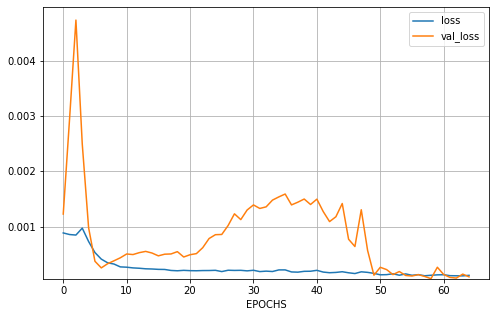

In [168]:
#plot the learning curve of the model
nn_plot_learning_curve(history)
plt.show()

In [169]:
y_pred=model.predict(X_train)
y_pred.shape

(1886, 5)

In [170]:
#predict the validation data set
y_pred = model.predict(X_train)

#scale predictiond and actuals
pred = yScaler.inverse_transform( y_pred[:,[0]]) 
actual = yScaler.inverse_transform( y_train )

#calculate the Mean Squared Error using the scaled values
error = mean_squared_error(pred, actual, squared=False)
print( 'ERROR: {:.4f}'.format(error) )

ERROR: 60.8565


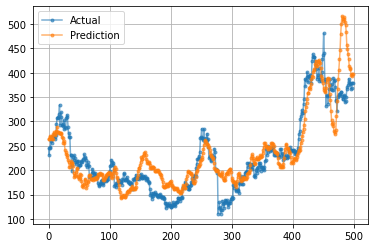

In [171]:
#plot the predictions vs. the actuals
plot_actual_pred( actual[-500:], pred[-500:] )

In [172]:
#predict the validation data set
y_pred = model.predict(X_test)

#scale predictiond and actuals
pred = yScaler.inverse_transform( y_pred[:,[0]])
actual = yScaler.inverse_transform( y_test )

#calculate the Mean Squared Error using the scaled values
error = mean_squared_error(pred, actual, squared=False)
print( 'ERROR: {:.4f}'.format(error) )

ERROR: 996.9468


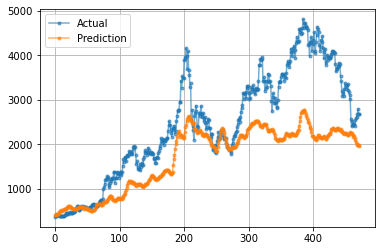

In [173]:
#plot the predictions vs. the actuals
plot_actual_pred( actual[-500:], pred[-500:] )

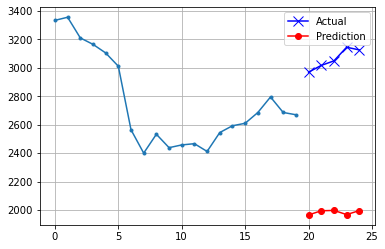

In [174]:
#Predict using the model
y_prediction = model.predict( toPredict )

#scale the y values
y_prediction = yScaler.inverse_transform( y_prediction )

#plot the actual values as well as future known actuals vs. future predictions
#NOTE: if FUTURES is > 1, the ,0 is needed to only plot the 1st value in the prediction
plot_series(actual[-20:], prediction, y_prediction[:,0]) 

In [175]:
#print the error
mean_squared_error( y_prediction[:,0], prediction, squared=False) 

1078.9882342799406

In [176]:
#1207

In [ ]:
#996